In [1]:
import math
from dataclasses import dataclass, field, InitVar, asdict
from typing import Union
from graphviz import Digraph


@dataclass(eq=False)
class Value:
    """ this is basically what we have at https://youtu.be/VMj-3S1tku0?t=5903 
    but built a bit differently"""
    data: float
    prev: tuple = field(compare=False, repr=False, default=())
    op: str = field(compare=False, repr=False, default='')
    label: str = field(compare=False, default='')
    grad: float = field(compare=False, default=0.0)

    def __post_init__(self, ):
            
        # build label from parts if not given
        if not self.label:
            if self.op in ('+', '*'):
                label = self.op.join(p.label for p in self.prev)
                self.label = f"({label})"
            if self.op in ('tanh', 'exp'):
                self.label = f"{self.op}({self.prev[0].label})"
            if self.op.startswith('^'):
                self.label = f"({self.prev[0].label}){self.op}"

    def _backward(self):
        """ placeholder for local backpropagation, 
        overridden in the operation methods for all except leaf nodes """
        pass

    def backward(self):
        """
        Backpropagate from this node all the way upstream
        """
        
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in topo[::-1]:
            node._backward()

    ### operations ###

    def __add__(self, other):
        """ Addition: return a new Value that has its descendants and backward pass set """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, prev=(self, other), op='+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        """ self * other: return a new Value that has its descendants and backward pass set """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, prev=(self, other), op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):  # other + self
        return self + other

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**(-1)

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __pow__(self, other: Union[int, float]):
        """ self ** other """
        if not isinstance(other, (int, float)):
            raise TypeError()
        out = Value(self.data**other, prev=(self, ), op=f'^{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        """ tanh: return a new Value that has its descendants and backward pass set """
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, prev=(self,), op='tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), prev=(self,), op='exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    ### visualization ###
    
    def viz(self):
        return Value._draw_dot(self)

    @staticmethod
    def _draw_dot(v, rankdir='TD'):
        dot = Digraph(format='svg', 
                      graph_attr={'rankdir': rankdir}
                     )
        nodes, edges = v._trace()
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label=f"{{ {n.op} | {n.label} | {n.data:.4f} (grad {n.grad:.4f}) }}", shape='record')
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)))
        return dot

    def _trace(self):
        nodes, edges = list(), list()
        def build(v):
            if v not in nodes:
                nodes.append(v)
                for child in v.prev:
                    edges.append((child, v))
                    build(child)
        build(self)
        return nodes, edges


v = (Value(2.0, label='a') * Value(3.0, label='b')) + Value(1.0, label='c')
v2 = v.tanh()
assert v.data == 7.0
assert {p.data for p in v.prev} == {1.0, 6.0}

In [2]:
import random
random.uniform(-1, 1)

0.4695804093492879

In [3]:
sum?

Signature: sum(iterable, /, start=0)
Docstring:
Return the sum of a 'start' value (default: 0) plus an iterable of numbers

When the iterable is empty, return the start value.
This function is intended specifically for use with numeric values and may
reject non-numeric types.
Type:      builtin_function_or_method

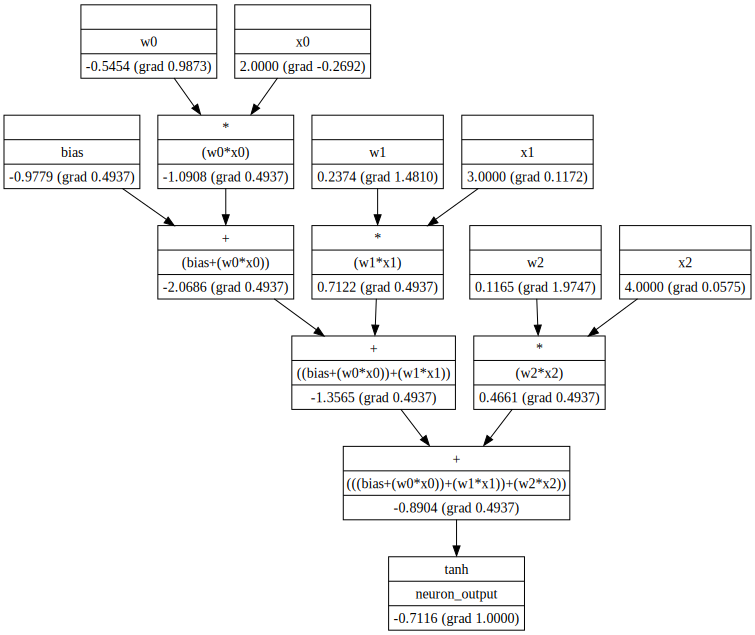

In [4]:
class Neuron:
    
    def __init__(self, n_inputs, label='neuron_output'):
        self.weights = [Value(random.uniform(-1, 1), label=f'w{i}') for i in range(n_inputs)]
        self.bias = Value(random.uniform(-1, 1), label='bias')
        self.label = label

    def __call__(self, x, add_labels=False):
        if add_labels:
            x = [Value(v, label=f'x{i}') for i, v in enumerate(x)]
        activation = sum((wi*xi for wi, xi in zip(self.weights, x)), start=self.bias)
        assert isinstance(activation, Value)
        out = activation.tanh()
        out.label = self.label
        return out

x = [2.0, 3.0, 4.0]

n = Neuron(3)
neuron_output = n(x, add_labels=True)
neuron_output.backward()
neuron_output.viz()

# test runs

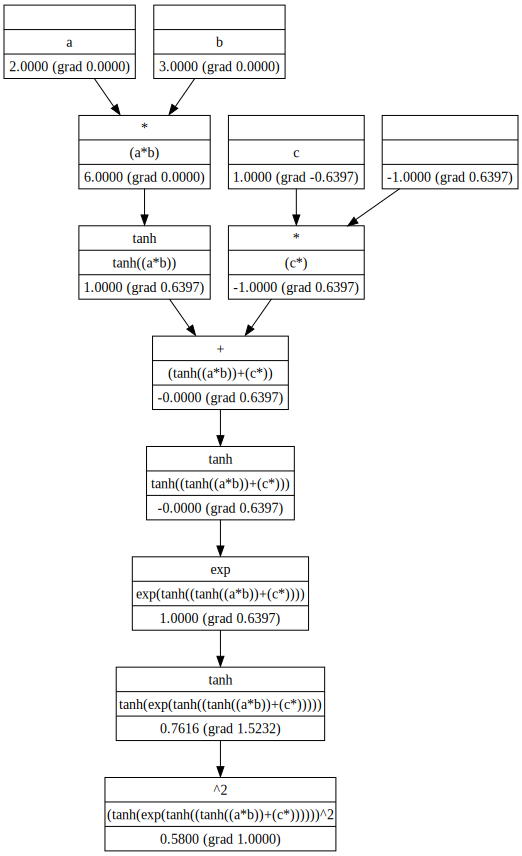

In [5]:


v = (Value(2.0, label='a') * Value(3.0, label='b')).tanh() - Value(1.0, label='c')
zyy = v.tanh().exp().tanh()**2

zyy.backward()
zyy.viz()

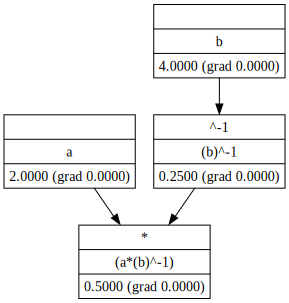

In [6]:
(Value(2.0, label='a') / Value(4.0, label='b')).viz()

In [7]:
import numpy as np

In [8]:
np.tanh(10)

0.9999999958776927

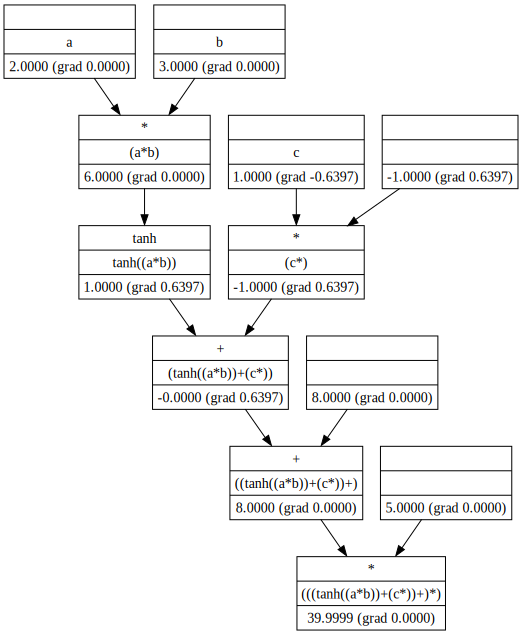

In [9]:
(5 * (8 + v)).viz()

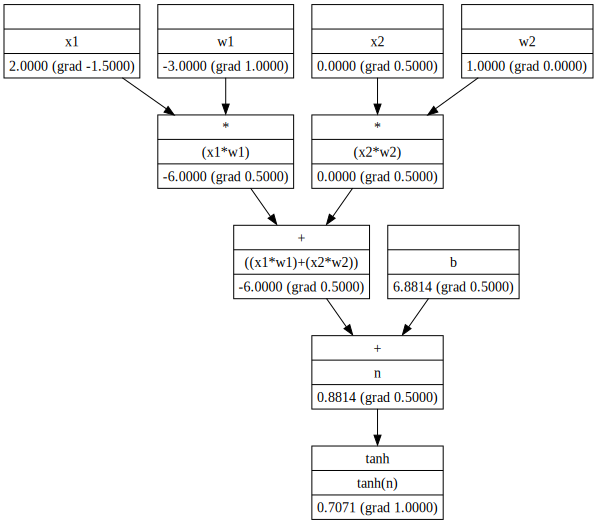

In [10]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358, label='b')

n = x1*w1 + x2*w2 + b
n.label = 'n'

o = n.tanh()

o.backward()
o.viz()

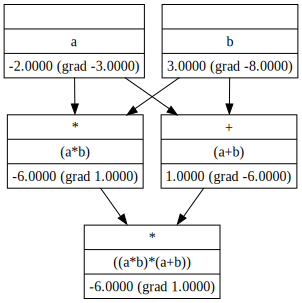

In [11]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a*b
d = a+b
e = c*d
e.backward()
e.viz()